In [1]:
%run -m ipy_startup
%run -m ipy_logging
%matplotlib inline
%load_ext rpy2.ipython
from musc_genomics.data_import import cgds, api, prep
from musc_genomics import common
from musc_genomics.data_modeling import modeling
from musc_genomics import data
from py_utils import set_utils
pd.set_option('max_info_rows', int(1E9))

# Load Cosmic Response Data


In [2]:
d_cosmic_prep = data.load('prepared', 'response_cosmic6')
d_cosmic_prep.info()

2016-08-06 18:28:47,210:DEBUG:research.project.manager: Loading saved data from location "/Users/eczech/data/research/musc_genomics/prepared/response_cosmic6.pkl"


<class 'pandas.core.frame.DataFrame'>
Int64Index: 216576 entries, 0 to 216575
Data columns (total 21 columns):
DATASET_VERSION        216576 non-null int64
IC50_RESULTS_ID        216576 non-null int64
COSMIC_ID              216576 non-null int64
DRUG_ID                216576 non-null int64
MAX_CONC_MICROMOLAR    216576 non-null float64
VALUE_IC50             216576 non-null float64
VALUE_AUC              216576 non-null float64
RMSE                   216576 non-null float64
TUMOR_ID               216576 non-null object
HAS_ES                 212774 non-null object
HAS_CN                 212774 non-null object
HAS_GE                 212774 non-null object
HAS_ME                 212774 non-null object
HAS_DR                 212774 non-null object
CANCER_TYPE            175006 non-null object
SITE                   216576 non-null object
HISTOLOGY              216576 non-null object
DRUG_NAME              216576 non-null object
SYNONYMS               116999 non-null object
TARGET         

### Normalize Tumor IDs

This is necessary to avoid common mistakes in aggregation due to the same tumor IDs being represented in different ways.  For example, the following ID's were found in the raw data to resolve to the same thing, with only irrelevant differences:

```
G-292 CLONE A141B1    G292CLONEA141B1
G-292_CLONE_A141B1    G292CLONEA141B1
HEP 3B2_1-7                  HEP3B217
HEP_3B2_1-7                  HEP3B217
KM-H2                            KMH2
KMH-2                            KMH2
NTERA-2 CL.D1              NTERA2CLD1
NTERA-2_CL_D1              NTERA2CLD1
PC-3 [JPC-3]                  PC3JPC3
PC-3_[JPC-3]                  PC3JPC3
UWB1.289                      UWB1289
UWB1_289                      UWB1289
```

In [3]:
norm_ids = common.normalize_tumor_ids(
    d_cosmic_prep['TUMOR_ID'], 
    source=common.SRC_COSMIC6, 
    verify_integrity=False
)

# Ensure that after normalizing tumor IDs, the cancer site, type, and histology associated with each
# does not conflict with the same values for the original IDs
c_o = ['CANCER_TYPE', 'SITE', 'HISTOLOGY']
cts = d_cosmic_prep.groupby(norm_ids).apply(lambda g: len(g[c_o].drop_duplicates()))
assert cts.max() == 1

### Analyze Effects of Duplicated Measurements

Number of cases with multiple IC50 measurements: 10661
Distribution of ranges of IC50 values for duplicated tests:


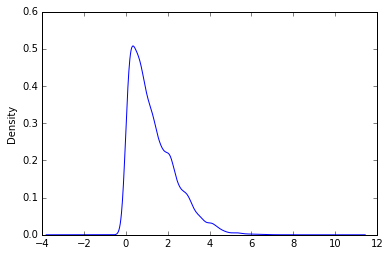

In [4]:
# Results are unique to TUMOR_ID + DRUG_NAME + IC50_RESULTS_ID combinations, with about 5%
# of them (~10k) having exactly 2 records for the same TUMOR_ID + DRUG_NAME (note that the
# DRUG_ID value is different in these cases)
cts = d_cosmic_prep.groupby(['TUMOR_ID', 'DRUG_NAME']).size()
print('Number of cases with multiple IC50 measurements: {}'.format(len(cts[cts > 1])))

print('Distribution of ranges of IC50 values for duplicated tests:')
std_dupe = d_cosmic_prep.groupby(['TUMOR_ID', 'DRUG_NAME'])\
    .apply(lambda g: g['VALUE_IC50'].max() - g['VALUE_IC50'].min() if len(g) > 1 else np.nan)
std_dupe.dropna().plot(kind='kde')

In [5]:
# Convert IC50 values to wide format, taking the mean value for duplicated measurements detailed above

# First check that the tumor and drug names are never null
id_cols = ['TUMOR_ID', 'DRUG_NAME']
for c in id_cols:
    assert np.all(d_cosmic_prep[c].notnull())

# Compute count of cases by target shape
def get_pivot(aggfunc):
    d = d_cosmic_prep.copy()
    index = ['TUMOR_ID', 'CANCER_TYPE', 'SITE', 'HISTOLOGY']
    columns = ['TARGET_PATHWAY', 'TARGET', 'DRUG_NAME']
    values = 'VALUE_IC50'
    d[index + columns] = d[index + columns].fillna('unknown')
    return d.pivot_table(values, index, columns, aggfunc)

# Ensure that there are no more duplicates found in the pivot operation than there are duplicates by TUMOR_ID + DRUG
assert get_pivot('count').max().max() == cts.max()

# Now compute actual values, taking the mean where necessary
d_cosmic = get_pivot('mean')
assert len(d_cosmic) == d_cosmic_prep['TUMOR_ID'].nunique()

d_cosmic.head()

TARGET_PATHWAY                                                 ABL signaling  \
TARGET                                                                   ABL   
DRUG_NAME                                                           AP-24534   
TUMOR_ID CANCER_TYPE SITE                   HISTOLOGY                          
201T     LUAD        lung                   carcinoma               0.587719   
22RV1    PRAD        prostate               carcinoma               2.429741   
2313287  STAD        stomach                carcinoma               1.858713   
42MGBA   GBM         central_nervous_system glioma                 -1.441932   
451LU    SKCM        skin                   malignant_melanoma     -0.786521   

TARGET_PATHWAY                                                            \
TARGET                                                                     
DRUG_NAME                                                      Nilotinib   
TUMOR_ID CANCER_TYPE SITE                   HISTOLOGY                      
201T     LUAD        lung                   carcinoma           3.642117   
22RV1    PRAD        prostate               carcinoma           3.645934   
2313287  STAD        stomach                carcinoma           3.378428   
42MGBA   GBM         central_nervous_system glioma              1.505494   
451LU    SKCM        skin                   malignant_melanoma  2.485392   

TARGET_PATHWAY                                                              \
TARGET                                                         ABL (T315I)   
DRUG_NAME                                                            GNF-2   
TUMOR_ID CANCER_TYPE SITE                   HISTOLOGY                        
201T     LUAD        lung                   carcinoma                  NaN   
22RV1    PRAD        prostate               carcinoma                  NaN   
2313287  STAD        stomach                carcinoma                  NaN   
42MGBA   GBM         central_nervous_system glioma                     NaN   
451LU    SKCM        skin                   malignant_melanoma         NaN   

TARGET_PATHWAY                                                                  \
TARGET                                                         ABL, KIT, PDGFR   
DRUG_NAME                                                             Imatinib   
TUMOR_ID CANCER_TYPE SITE                   HISTOLOGY                            
201T     LUAD        lung                   carcinoma                      NaN   
22RV1    PRAD        prostate               carcinoma                      NaN   
2313287  STAD        stomach                carcinoma                      NaN   
42MGBA   GBM         central_nervous_system glioma                         NaN   
451LU    SKCM        skin                   malignant_melanoma             NaN   

TARGET_PATHWAY                                                                       \
TARGET                                                         ABL, SRC, KIT, PDGFR   
DRUG_NAME                                                                 Dasatinib   
TUMOR_ID CANCER_TYPE SITE                   HISTOLOGY                                 
201T     LUAD        lung                   carcinoma                           NaN   
22RV1    PRAD        prostate               carcinoma                           NaN   
2313287  STAD        stomach                carcinoma                           NaN   
42MGBA   GBM         central_nervous_system glioma                              NaN   
451LU    SKCM        skin                   malignant_melanoma                  NaN   

TARGET_PATHWAY                                                                             \
TARGET                                                         LOK, LTK, TRCB, ABL(T315I)   
DRUG_NAME                                                                     HG-5-113-01   
TUMOR_ID CANCER_TYPE SITE                   HISTOLOGY                                    

# Load CGDS Features

In [8]:
d_cgds = data.load('prepared', 'features_raw')
d_cgds.iloc[:5, :10]

2016-08-06 18:29:11,021:DEBUG:research.project.manager: Loading saved data from location "/Users/eczech/data/research/musc_genomics/prepared/features_raw.pkl"


FEATURE,CN:A1BG,CN:A1BG-AS1,CN:A1CF,CN:A2M,CN:A2ML1,CN:A4GALT,CN:A4GNT,CN:AAAS,CN:AACS,CN:AACSP1
TUMOR_ID,,,,,,,,,,
1321N1,-0.15440,-0.15440,-0.09850,-0.1819,-0.1819,-0.1732,0.25750,-0.04040,-0.1284,0.1682
143B,-0.21200,-0.21200,0.15800,-0.1753,-0.1753,-0.2536,0.20600,-0.14450,-0.2757,0.2150
22RV1,-0.08084,-0.08084,-0.00250,0.4486,0.4486,-0.0574,-0.03030,0.46490,0.4406,-0.0518
2313287,-0.03310,-0.03310,-0.05348,-0.1917,-0.1917,-0.0512,-0.04608,-0.01474,-0.0516,-0.0514
253JBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Merge

In [9]:
s_diff = set_utils.analyze_sets(
    common.normalize_tumor_ids(d_cgds.index.values, source=common.SRC_CGDS),
    common.normalize_tumor_ids(d_cosmic.reset_index()['TUMOR_ID'], source=common.SRC_COSMIC6),
    names=['CGDS', 'COSMIC'], items=True
)
s_diff['Stats']

{'InBoth': '643 (46.33%)',
 'InOnlyCGDS': '376 (27.09%)',
 'InOnlyCOSMIC': '369 (26.59%)',
 'InOnlyOne': '745 (53.67%)'}

In [15]:
d_cgds.loc['SNU685'].filter(regex='^CL')

FEATURE
CL:CANCER_TYPE           solid
CL:HISTOLOGY         carcinoma
CL:PRIMARY_SITE    endometrium
CL:GENDER               female
Name: SNU685, dtype: object

In [19]:
d_cosmic.reset_index(level=['CANCER_TYPE', 'SITE', 'HISTOLOGY']).head()

TARGET_PATHWAY CANCER_TYPE                    SITE           HISTOLOGY  \
TARGET                                                                   
DRUG_NAME                                                                
TUMOR_ID                                                                 
201T                  LUAD                    lung           carcinoma   
22RV1                 PRAD                prostate           carcinoma   
2313287               STAD                 stomach           carcinoma   
42MGBA                 GBM  central_nervous_system              glioma   
451LU                 SKCM                    skin  malignant_melanoma   

TARGET_PATHWAY ABL signaling                                        \
TARGET                   ABL           ABL (T315I) ABL, KIT, PDGFR   
DRUG_NAME           AP-24534 Nilotinib       GNF-2        Imatinib   
TUMOR_ID                                                             
201T                0.587719  3.642117         NaN             NaN   
22RV1               2.429741  3.645934         NaN             NaN   
2313287             1.858713  3.378428         NaN             NaN   
42MGBA             -1.441932  1.505494         NaN             NaN   
451LU              -0.786521  2.485392         NaN             NaN   

TARGET_PATHWAY                                                  \
TARGET         ABL, SRC, KIT, PDGFR LOK, LTK, TRCB, ABL(T315I)   
DRUG_NAME                 Dasatinib                HG-5-113-01   
TUMOR_ID                                                         
201T                            NaN                        NaN   
22RV1                           NaN                   1.683271   
2313287                         NaN                        NaN   
42MGBA                          NaN                        NaN   
451LU                           NaN                   2.515805   

TARGET_PATHWAY                    ...          other               \
TARGET         SRC family, ABL    ...           TIE2    TNF alpha   
DRUG_NAME             WH-4-023    ...     KIN001-236 Lenalidomide   
TUMOR_ID                          ...                               
201T                       NaN    ...       4.156056     4.749040   
22RV1                      NaN    ...       4.096331     4.454144   
2313287                    NaN    ...       4.749415     4.292865   
42MGBA                     NaN    ...       4.132734     3.587407   
451LU                      NaN    ...       4.518831     3.825820   

TARGET_PATHWAY                                                                 \
TARGET         TPL2,COT(M3K8) gamma-secretase               unknown             
DRUG_NAME          KIN001-266      BMS-708163 Z-LLNle-CHO     FH535  Shikonin   
TUMOR_ID                                                                        
201T                 3.294363        4.146932         NaN  1.067009 -0.178780   
22RV1                3.272366        3.650493         NaN  1.101590  1.203081   
2313287              2.895975        4.050002         NaN  1.296307  0.261285   
42MGBA               2.935137        4.184062         NaN  3.751758  0.643791   
451LU                2.920207        4.311843         NaN  1.105253 -0.938597   

TARGET_PATHWAY  p53 pathway                           
TARGET                 MDM2                     MDMX  
DRUG_NAME      JNJ-26854165 Nutlin-3a (-) NSC-207895  
TUMOR_ID                                              
201T               4.129386      4.927490   5.756647  
22RV1              2.835527      2.403369   3.704255  
2313287            2.493011      2.906627   3.111120  
42MGBA             1.671162      4.320196   5.724220  
451LU              1.889850      3.496920   2.528633  

[5 rows x 255 columns]

In [58]:
meta_cols = ['CANCER_TYPE', 'SITE', 'HISTOLOGY']
d_drug = d_cosmic.reset_index(level=meta_cols)
d_drug.columns = [':'.join([c for c in col if c]) for col in d_drug]
d_drug = d_drug.add_prefix('RES:')


d_all = pd.concat([
        d_cgds.assign(ID1=np.arange(len(d_cgds))), 
        d_drug.assign(ID2=np.arange(len(d_drug)))
], axis=1, join='outer')
d_all.index.name = 'TUMOR_ID'

# Remove any records that failed to join
mask = (d_all['ID1'].notnull()) & (d_all['ID2'].notnull())
print('{} records out of {} failed to join on tumor ID'.format(len(d_all) - mask.sum(), len(d_all)))
d_all = d_all[mask]

assert not np.any(d_all.reset_index()['TUMOR_ID'].duplicated())

d_all.info()

747 records out of 1389 failed to join on tumor ID
<class 'pandas.core.frame.DataFrame'>
Index: 642 entries, 22RV1 to ZR7530
Columns: 107633 entries, CN:A1BG to ID2
dtypes: float64(107626), object(7)
memory usage: 527.2+ MB


In [60]:
d_all.head()

FEATURE,CN:A1BG,CN:A1BG-AS1,CN:A1CF,CN:A2M,CN:A2ML1,CN:A4GALT,CN:A4GNT,CN:AAAS,CN:AACS,CN:AACSP1,...,RES:other:TNF alpha:Lenalidomide,"RES:other:TPL2,COT(M3K8):KIN001-266",RES:other:gamma-secretase:BMS-708163,RES:other:gamma-secretase:Z-LLNle-CHO,RES:other:unknown:FH535,RES:other:unknown:Shikonin,RES:p53 pathway:MDM2:JNJ-26854165,RES:p53 pathway:MDM2:Nutlin-3a (-),RES:p53 pathway:MDMX:NSC-207895,ID2
TUMOR_ID,,,,,,,,,,,,,,,,,,,,,
22RV1,-0.08084,-0.08084,-0.00250,0.4486,0.4486,-0.05740,-0.03030,0.46490,0.4406,-0.0518,...,4.454144,3.272366,3.650493,NaN,1.101590,1.203081,2.835527,2.403369,3.704255,1.0
2313287,-0.03310,-0.03310,-0.05348,-0.1917,-0.1917,-0.05120,-0.04608,-0.01474,-0.0516,-0.0514,...,4.292865,2.895975,4.050002,NaN,1.296307,0.261285,2.493011,2.906627,3.111120,2.0
42MGBA,0.03220,0.03220,-0.05220,-0.3905,-0.3905,-0.01630,-0.26860,-0.30590,0.0857,0.2794,...,3.587407,2.935137,4.184062,NaN,3.751758,0.643791,1.671162,4.320196,5.724220,3.0
5637,-0.03514,-0.03514,-0.49350,-0.0657,-0.0657,-0.03961,0.05133,0.01120,0.3015,0.4044,...,3.862487,2.575704,4.110246,NaN,1.993463,2.522932,1.411154,4.193885,2.780774,5.0
639V,0.08280,0.08280,0.05900,0.3126,0.3126,0.33200,0.09990,-0.08414,-0.1396,0.0901,...,2.437845,3.260532,4.041213,NaN,0.604865,-1.408402,2.062012,2.699072,2.423240,6.0


# Export

In [63]:
data.save('prepared', 'modeling_data_raw_02', d_all)

2016-08-06 19:04:30,126:DEBUG:research.project.manager: Saving data to location "/Users/eczech/data/research/musc_genomics/prepared/modeling_data_raw_02.pkl"


'/Users/eczech/data/research/musc_genomics/prepared/modeling_data_raw_02.pkl'